# Options Pricing: Delta Hedging


This notebook implements:
- Delta hedging with detailed P&L attribution
- Greeks calculations (Delta, Gamma, Theta) for hedging
- Hedging error analysis
- Impact of rebalancing frequency on hedging performance

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

## Black-Scholes Functions

In [2]:
def black_scholes_d1(S, K, r, d, sigma, T):
    """Calculate d1 parameter for Black-Scholes"""
    if T <= 0:
        return 0.0
    return (np.log(S/K) + (r - d + sigma**2 / 2) * T) / (sigma * np.sqrt(T))

def black_scholes_d2(S, K, r, d, sigma, T):
    """Calculate d2 parameter for Black-Scholes"""
    if T <= 0:
        return 0.0
    d1 = black_scholes_d1(S, K, r, d, sigma, T)
    return d1 - sigma * np.sqrt(T)

def black_scholes_call(S, K, r, d, sigma, T):
    """Black-Scholes European call option price"""
    if T <= 0:
        return max(S - K, 0)
    d1 = black_scholes_d1(S, K, r, d, sigma, T)
    d2 = black_scholes_d2(S, K, r, d, sigma, T)
    return S * np.exp(-d * T) * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

def black_scholes_put(S, K, r, d, sigma, T):
    """Black-Scholes European put option price"""
    if T <= 0:
        return max(K - S, 0)
    d1 = black_scholes_d1(S, K, r, d, sigma, T)
    d2 = black_scholes_d2(S, K, r, d, sigma, T)
    return K * np.exp(-r * T) * norm.cdf(-d2) - S * np.exp(-d * T) * norm.cdf(-d1)

## Greeks Calculations 

In [3]:
def calculate_delta_call(S, K, r, d, sigma, T):
    """Delta for call option - hedge ratio"""
    if T <= 0:
        return 1.0 if S > K else 0.0
    d1 = black_scholes_d1(S, K, r, d, sigma, T)
    return np.exp(-d * T) * norm.cdf(d1)

def calculate_delta_put(S, K, r, d, sigma, T):
    """Delta for put option - hedge ratio"""
    if T <= 0:
        return -1.0 if S < K else 0.0
    d1 = black_scholes_d1(S, K, r, d, sigma, T)
    return np.exp(-d * T) * (norm.cdf(d1) - 1)

def calculate_gamma(S, K, r, d, sigma, T):
    """Gamma - rate of change of delta (hedging error sensitivity)"""
    if T <= 0:
        return 0.0
    d1 = black_scholes_d1(S, K, r, d, sigma, T)
    return np.exp(-d * T) * norm.pdf(d1) / (S * sigma * np.sqrt(T))

def calculate_theta_call(S, K, r, d, sigma, T):
    """Theta for call option - time decay component"""
    if T <= 0:
        return 0.0
    d1 = black_scholes_d1(S, K, r, d, sigma, T)
    d2 = black_scholes_d2(S, K, r, d, sigma, T)
    term1 = -S * np.exp(-d * T) * norm.pdf(d1) * sigma / (2 * np.sqrt(T))
    term2 = d * S * np.exp(-d * T) * norm.cdf(d1)
    term3 = -r * K * np.exp(-r * T) * norm.cdf(d2)
    return term1 + term2 + term3

def calculate_theta_put(S, K, r, d, sigma, T):
    """Theta for put option - time decay component"""
    if T <= 0:
        return 0.0
    d1 = black_scholes_d1(S, K, r, d, sigma, T)
    d2 = black_scholes_d2(S, K, r, d, sigma, T)
    term1 = -S * np.exp(-d * T) * norm.pdf(d1) * sigma / (2 * np.sqrt(T))
    term2 = -d * S * np.exp(-d * T) * norm.cdf(-d1)
    term3 = r * K * np.exp(-r * T) * norm.cdf(-d2)
    return term1 + term2 + term3

## Delta Hedging with P&L Attribution

In [4]:
def delta_hedging_simulation(S0, K, r, d, sigma, T, num_steps, option_type='call', 
                                      transaction_cost=0.0, seed=None):
    """
    Delta hedging simulation with P&L attribution
    
    Parameters:
    -----------
    S0 : float
        Initial stock price
    K : float
        Strike price
    r : float
        Risk-free rate
    d : float
        Dividend yield
    sigma : float
        Volatility
    T : float
        Time to maturity (years)
    num_steps : int
        Number of rebalancing steps
    option_type : str
        'call' or 'put'
    transaction_cost : float
        Transaction cost as a percentage of stock value
    seed : int
        Random seed for reproducibility
    
    Returns:
    --------
    results : dict
        Dictionary containing all hedging results and P&L components
    """
    if seed is not None:
        np.random.seed(seed)
    
    dt = T / num_steps
    
    # Initialize arrays
    stock_path = np.zeros(num_steps + 1)
    delta_path = np.zeros(num_steps + 1)
    gamma_path = np.zeros(num_steps + 1)
    theta_path = np.zeros(num_steps + 1)
    option_value_path = np.zeros(num_steps + 1)
    hedge_portfolio = np.zeros(num_steps + 1)
    cash_account = np.zeros(num_steps + 1)
    time_path = np.zeros(num_steps + 1)
    transaction_costs = np.zeros(num_steps + 1)
    
    # P&L attribution arrays
    delta_pnl = np.zeros(num_steps + 1)
    gamma_pnl = np.zeros(num_steps + 1)
    theta_pnl = np.zeros(num_steps + 1)
    
    # Initial values
    stock_path[0] = S0
    time_path[0] = 0
    
    if option_type == 'call':
        option_value_path[0] = black_scholes_call(S0, K, r, d, sigma, T)
        delta_path[0] = calculate_delta_call(S0, K, r, d, sigma, T)
        theta_path[0] = calculate_theta_call(S0, K, r, d, sigma, T)
    else:
        option_value_path[0] = black_scholes_put(S0, K, r, d, sigma, T)
        delta_path[0] = calculate_delta_put(S0, K, r, d, sigma, T)
        theta_path[0] = calculate_theta_put(S0, K, r, d, sigma, T)
    
    gamma_path[0] = calculate_gamma(S0, K, r, d, sigma, T)
    
    # Initial hedge: short option, long delta shares
    cash_account[0] = option_value_path[0] - delta_path[0] * S0
    hedge_portfolio[0] = 0.0  # Self-financing at start
    
    # Simulate stock path using GBM
    for t in range(1, num_steps + 1):
        Z = np.random.standard_normal()
        stock_path[t] = stock_path[t - 1] * np.exp((r - d - 0.5 * sigma**2) * dt + 
                                                     sigma * np.sqrt(dt) * Z)
        time_path[t] = t * dt
    
    # Rebalance hedge portfolio
    for t in range(1, num_steps + 1):
        time_remaining = T - time_path[t]
        
        # Calculate new Greeks and option value
        if time_remaining > 1e-10:
            if option_type == 'call':
                option_value_path[t] = black_scholes_call(stock_path[t], K, r, d, sigma, time_remaining)
                new_delta = calculate_delta_call(stock_path[t], K, r, d, sigma, time_remaining)
                theta_path[t] = calculate_theta_call(stock_path[t], K, r, d, sigma, time_remaining)
            else:
                option_value_path[t] = black_scholes_put(stock_path[t], K, r, d, sigma, time_remaining)
                new_delta = calculate_delta_put(stock_path[t], K, r, d, sigma, time_remaining)
                theta_path[t] = calculate_theta_put(stock_path[t], K, r, d, sigma, time_remaining)
            
            gamma_path[t] = calculate_gamma(stock_path[t], K, r, d, sigma, time_remaining)
        else:
            # At maturity
            if option_type == 'call':
                option_value_path[t] = max(stock_path[t] - K, 0)
            else:
                option_value_path[t] = max(K - stock_path[t], 0)
            new_delta = 1.0 if (option_type == 'call' and stock_path[t] > K) else \
                       (-1.0 if (option_type == 'put' and stock_path[t] < K) else 0.0)
            gamma_path[t] = 0.0
            theta_path[t] = 0.0
        
        # Calculate P&L components
        dS = stock_path[t] - stock_path[t - 1]
        
        # Delta P&L (first-order: linear in stock price change)
        delta_pnl[t] = delta_path[t - 1] * dS
        
        # Gamma P&L (second-order: quadratic in stock price change)
        gamma_pnl[t] = 0.5 * gamma_path[t - 1] * dS**2
        
        # Theta P&L (time decay)
        theta_pnl[t] = theta_path[t - 1] * dt
        
        # Update cash account with interest
        cash_account[t] = cash_account[t - 1] * np.exp(r * dt)
        
        # Rebalancing transaction
        delta_change = new_delta - delta_path[t - 1]
        rebalance_cost = abs(delta_change) * stock_path[t] * transaction_cost
        transaction_costs[t] = rebalance_cost
        
        # Update cash account for stock purchase/sale
        cash_account[t] -= delta_change * stock_path[t] + rebalance_cost
        
        # Update delta
        delta_path[t] = new_delta
        
        # Calculate total portfolio value (stocks + cash - option)
        hedge_portfolio[t] = delta_path[t] * stock_path[t] + cash_account[t] - option_value_path[t]
    
    # Final P&L
    final_payoff = option_value_path[-1]
    total_pnl = hedge_portfolio[-1]
    
    # Compile results
    results = {
        'total_pnl': total_pnl,
        'stock_path': stock_path,
        'delta_path': delta_path,
        'gamma_path': gamma_path,
        'theta_path': theta_path,
        'option_value_path': option_value_path,
        'hedge_portfolio': hedge_portfolio,
        'cash_account': cash_account,
        'time_path': time_path,
        'delta_pnl': delta_pnl,
        'gamma_pnl': gamma_pnl,
        'theta_pnl': theta_pnl,
        'transaction_costs': transaction_costs,
        'total_transaction_cost': np.sum(transaction_costs),
        'final_option_value': final_payoff
    }
    
    return results

## Discrete Hedging Error Analysis

In [5]:
def analyze_hedging_error(S0, K, r, d, sigma, T, rebalance_frequencies, num_simulations=100, 
                         option_type='call', seed=None):
    """
    Analyze hedging error as a function of rebalancing frequency
    
    Parameters:
    -----------
    rebalance_frequencies : list
        List of number of rebalancing steps to test
    num_simulations : int
        Number of Monte Carlo simulations per frequency
    
    Returns:
    --------
    results : dict
        Dictionary with mean and std of P&L for each frequency
    """
    results = {
        'frequencies': rebalance_frequencies,
        'mean_pnl': [],
        'std_pnl': [],
        'mean_abs_error': [],
        'rmse': []
    }
    
    for freq in rebalance_frequencies:
        pnls = []
        for sim in range(num_simulations):
            sim_seed = seed + sim if seed is not None else None
            hedge_results = delta_hedging_simulation(
                S0, K, r, d, sigma, T, freq, option_type, seed=sim_seed
            )
            pnls.append(hedge_results['total_pnl'])
        
        results['mean_pnl'].append(np.mean(pnls))
        results['std_pnl'].append(np.std(pnls))
        results['mean_abs_error'].append(np.mean(np.abs(pnls)))
        results['rmse'].append(np.sqrt(np.mean(np.array(pnls)**2)))
    
    return results

## Parameters Setup

In [6]:
# Base Parameters
S0 = 100.0      # Initial stock price
K = 100.0       # Strike price
r = 0.05        # Risk-free rate
d = 0.02        # Dividend yield
sigma = 0.2     # Volatility
T = 1.0         # Time to maturity
option_type = 'call'

## Single Delta Hedging Simulation with P&L Attribution

In [7]:
print("="*70)
print("DELTA HEDGING SIMULATION - DETAILED ANALYSIS")
print("="*70)

num_hedge_steps = 50
hedge_results = delta_hedging_simulation(
    S0, K, r, d, sigma, T, num_hedge_steps, option_type, 
    transaction_cost=0.001, seed=42
)

print(f"\nHedging Parameters:")
print(f"  Rebalancing Steps:  {num_hedge_steps}")
print(f"  Transaction Cost:   0.1%")
print(f"  Initial Stock:      ${S0:.2f}")
print(f"  Final Stock:        ${hedge_results['stock_path'][-1]:.2f}")

print(f"\nP&L Attribution:")
print(f"  Total P&L:          ${hedge_results['total_pnl']:.6f}")
print(f"  Delta P&L:          ${np.sum(hedge_results['delta_pnl']):.6f}")
print(f"  Gamma P&L:          ${np.sum(hedge_results['gamma_pnl']):.6f}")
print(f"  Theta P&L:          ${np.sum(hedge_results['theta_pnl']):.6f}")
print(f"  Transaction Costs:  ${hedge_results['total_transaction_cost']:.6f}")
print(f"  Final Option Value: ${hedge_results['final_option_value']:.6f}")
print()

DELTA HEDGING SIMULATION - DETAILED ANALYSIS

Hedging Parameters:
  Rebalancing Steps:  50
  Transaction Cost:   0.1%
  Initial Stock:      $100.00
  Final Stock:        $73.43

P&L Attribution:
  Total P&L:          $-0.687547
  Delta P&L:          $-8.198098
  Gamma P&L:          $2.669855
  Theta P&L:          $-3.786448
  Transaction Costs:  $0.161856
  Final Option Value: $0.000000



## Visualization: Single Delta Hedging Path

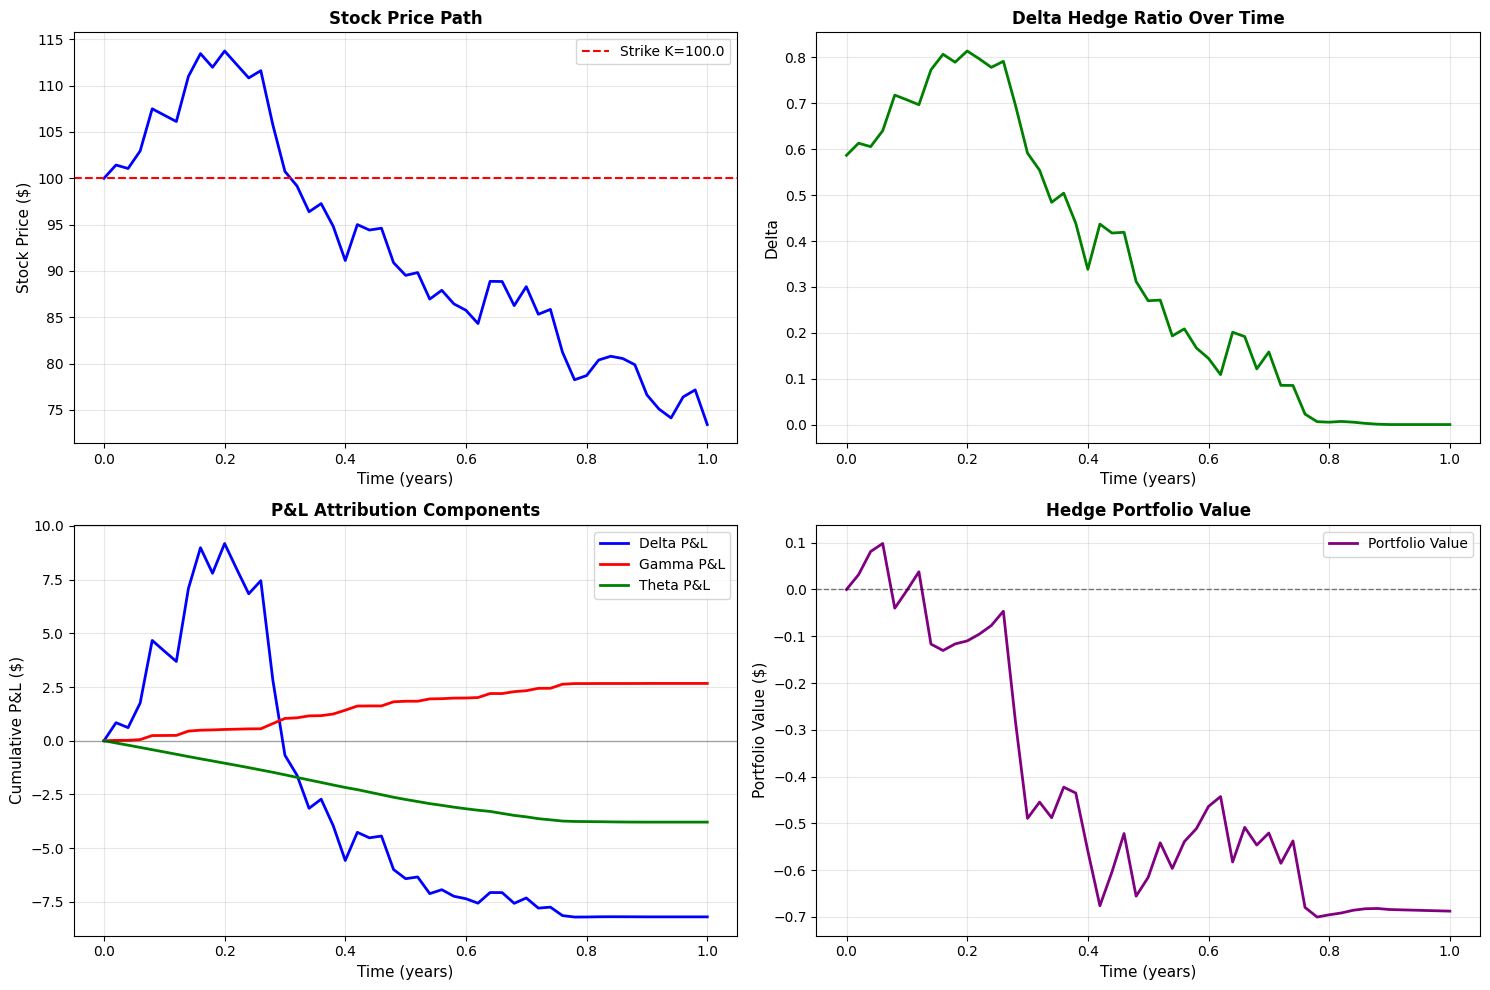

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Stock Price Path
axes[0, 0].plot(hedge_results['time_path'], hedge_results['stock_path'], 'b-', linewidth=2)
axes[0, 0].axhline(y=K, color='r', linestyle='--', label=f'Strike K={K}')
axes[0, 0].set_xlabel('Time (years)', fontsize=11)
axes[0, 0].set_ylabel('Stock Price ($)', fontsize=11)
axes[0, 0].set_title('Stock Price Path', fontsize=12, fontweight='bold')
axes[0, 0].legend(fontsize=10)
axes[0, 0].grid(True, alpha=0.3)

# Delta Path
axes[0, 1].plot(hedge_results['time_path'], hedge_results['delta_path'], 'g-', linewidth=2)
axes[0, 1].set_xlabel('Time (years)', fontsize=11)
axes[0, 1].set_ylabel('Delta', fontsize=11)
axes[0, 1].set_title('Delta Hedge Ratio Over Time', fontsize=12, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# Cumulative P&L Components
cumulative_delta_pnl = np.cumsum(hedge_results['delta_pnl'])
cumulative_gamma_pnl = np.cumsum(hedge_results['gamma_pnl'])
cumulative_theta_pnl = np.cumsum(hedge_results['theta_pnl'])

axes[1, 0].plot(hedge_results['time_path'], cumulative_delta_pnl, 'b-', 
                label='Delta P&L', linewidth=2)
axes[1, 0].plot(hedge_results['time_path'], cumulative_gamma_pnl, 'r-', 
                label='Gamma P&L', linewidth=2)
axes[1, 0].plot(hedge_results['time_path'], cumulative_theta_pnl, 'g-', 
                label='Theta P&L', linewidth=2)
axes[1, 0].axhline(y=0, color='k', linestyle='-', linewidth=1, alpha=0.3)
axes[1, 0].set_xlabel('Time (years)', fontsize=11)
axes[1, 0].set_ylabel('Cumulative P&L ($)', fontsize=11)
axes[1, 0].set_title('P&L Attribution Components', fontsize=12, fontweight='bold')
axes[1, 0].legend(fontsize=10)
axes[1, 0].grid(True, alpha=0.3)

# Portfolio Value
axes[1, 1].plot(hedge_results['time_path'], hedge_results['hedge_portfolio'], 
                'purple', linewidth=2, label='Portfolio Value')
axes[1, 1].axhline(y=0, color='k', linestyle='--', linewidth=1, alpha=0.5)
axes[1, 1].set_xlabel('Time (years)', fontsize=11)
axes[1, 1].set_ylabel('Portfolio Value ($)', fontsize=11)
axes[1, 1].set_title('Hedge Portfolio Value', fontsize=12, fontweight='bold')
axes[1, 1].legend(fontsize=10)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Multiple Delta Hedging Simulations

In [9]:
print("="*70)
print("MULTIPLE DELTA HEDGING SIMULATIONS")
print("="*70)

num_hedge_sims = 100
hedge_steps = 50
hedge_pnls = []
gamma_pnls = []
theta_pnls = []
transaction_cost_list = []

for i in range(num_hedge_sims):
    results = delta_hedging_simulation(
        S0, K, r, d, sigma, T, hedge_steps, option_type, 
        transaction_cost=0.001, seed=i
    )
    hedge_pnls.append(results['total_pnl'])
    gamma_pnls.append(np.sum(results['gamma_pnl']))
    theta_pnls.append(np.sum(results['theta_pnl']))
    transaction_cost_list.append(results['total_transaction_cost'])

hedge_pnls = np.array(hedge_pnls)
gamma_pnls = np.array(gamma_pnls)
theta_pnls = np.array(theta_pnls)
transaction_cost_list = np.array(transaction_cost_list)

print(f"\nResults from {num_hedge_sims} simulations ({hedge_steps} rebalancing steps):")
print(f"  Mean Total P&L:        ${np.mean(hedge_pnls):.6f}")
print(f"  Std Dev P&L:           ${np.std(hedge_pnls):.6f}")
print(f"  Min P&L:               ${np.min(hedge_pnls):.6f}")
print(f"  Max P&L:               ${np.max(hedge_pnls):.6f}")
print(f"  Mean Gamma P&L:        ${np.mean(gamma_pnls):.6f}")
print(f"  Mean Theta P&L:        ${np.mean(theta_pnls):.6f}")
print(f"  Mean Transaction Cost: ${np.mean(transaction_cost_list):.6f}")
print()

MULTIPLE DELTA HEDGING SIMULATIONS

Results from 100 simulations (50 rebalancing steps):
  Mean Total P&L:        $-1.326962
  Std Dev P&L:           $1.012520
  Min P&L:               $-3.966965
  Max P&L:               $0.927677
  Mean Gamma P&L:        $3.707305
  Mean Theta P&L:        $-5.002525
  Mean Transaction Cost: $0.214621



## Visualization: Multiple Delta Hedging Simulations

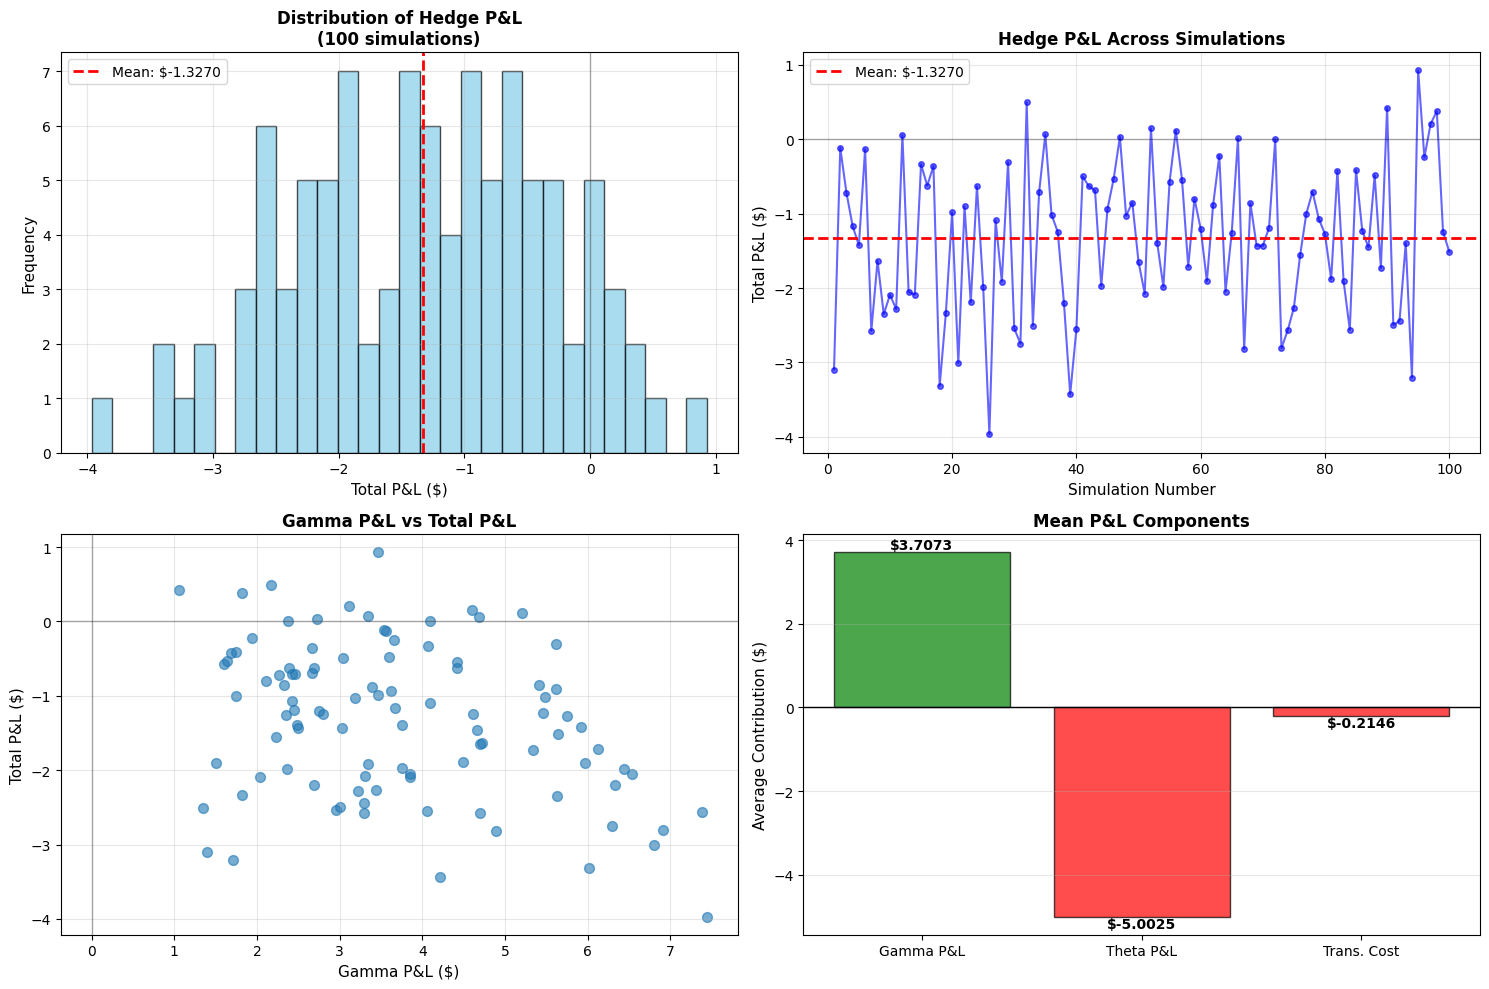

In [10]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# P&L Distribution
axes[0, 0].hist(hedge_pnls, bins=30, edgecolor='black', alpha=0.7, color='skyblue')
axes[0, 0].axvline(x=np.mean(hedge_pnls), color='r', linestyle='--', linewidth=2, 
                   label=f'Mean: ${np.mean(hedge_pnls):.4f}')
axes[0, 0].axvline(x=0, color='k', linestyle='-', linewidth=1, alpha=0.3)
axes[0, 0].set_xlabel('Total P&L ($)', fontsize=11)
axes[0, 0].set_ylabel('Frequency', fontsize=11)
axes[0, 0].set_title(f'Distribution of Hedge P&L\n({num_hedge_sims} simulations)', 
                     fontsize=12, fontweight='bold')
axes[0, 0].legend(fontsize=10)
axes[0, 0].grid(True, alpha=0.3)

# P&L Over Simulations
axes[0, 1].plot(range(1, num_hedge_sims + 1), hedge_pnls, 'bo-', alpha=0.6, markersize=4)
axes[0, 1].axhline(y=np.mean(hedge_pnls), color='r', linestyle='--', linewidth=2, 
                   label=f'Mean: ${np.mean(hedge_pnls):.4f}')
axes[0, 1].axhline(y=0, color='k', linestyle='-', linewidth=1, alpha=0.3)
axes[0, 1].set_xlabel('Simulation Number', fontsize=11)
axes[0, 1].set_ylabel('Total P&L ($)', fontsize=11)
axes[0, 1].set_title('Hedge P&L Across Simulations', fontsize=12, fontweight='bold')
axes[0, 1].legend(fontsize=10)
axes[0, 1].grid(True, alpha=0.3)

# Gamma P&L vs Total P&L
axes[1, 0].scatter(gamma_pnls, hedge_pnls, alpha=0.6, s=50)
axes[1, 0].axhline(y=0, color='k', linestyle='-', linewidth=1, alpha=0.3)
axes[1, 0].axvline(x=0, color='k', linestyle='-', linewidth=1, alpha=0.3)
axes[1, 0].set_xlabel('Gamma P&L ($)', fontsize=11)
axes[1, 0].set_ylabel('Total P&L ($)', fontsize=11)
axes[1, 0].set_title('Gamma P&L vs Total P&L', fontsize=12, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# Component Contributions
components = ['Gamma P&L', 'Theta P&L', 'Trans. Cost']
values = [np.mean(gamma_pnls), np.mean(theta_pnls), -np.mean(transaction_cost_list)]
colors = ['green' if v > 0 else 'red' for v in values]

axes[1, 1].bar(components, values, color=colors, alpha=0.7, edgecolor='black')
axes[1, 1].axhline(y=0, color='k', linestyle='-', linewidth=1)
axes[1, 1].set_ylabel('Average Contribution ($)', fontsize=11)
axes[1, 1].set_title('Mean P&L Components', fontsize=12, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for i, v in enumerate(values):
    axes[1, 1].text(i, v, f'${v:.4f}', ha='center', 
                    va='bottom' if v > 0 else 'top', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

## Hedging Error vs Rebalancing Frequency

In [11]:
print("="*70)
print("HEDGING ERROR ANALYSIS - REBALANCING FREQUENCY")
print("="*70)

rebalance_freqs = [10, 25, 50, 100, 250, 500]
num_sims_freq = 50

error_analysis = analyze_hedging_error(
    S0, K, r, d, sigma, T, rebalance_freqs, num_sims_freq, option_type, seed=42
)

print(f"\nRebalancing Frequency Analysis ({num_sims_freq} simulations each):")
print("-" * 70)
print(f"{'Steps':<10} {'Mean P&L':<15} {'Std Dev':<15} {'RMSE':<15}")
print("-" * 70)
for i, freq in enumerate(error_analysis['frequencies']):
    print(f"{freq:<10} ${error_analysis['mean_pnl'][i]:<14.6f} "
          f"${error_analysis['std_pnl'][i]:<14.6f} ${error_analysis['rmse'][i]:<14.6f}")
print()

HEDGING ERROR ANALYSIS - REBALANCING FREQUENCY

Rebalancing Frequency Analysis (50 simulations each):
----------------------------------------------------------------------
Steps      Mean P&L        Std Dev         RMSE           
----------------------------------------------------------------------
10         $-1.451333      $2.103864       $2.555897      
25         $-1.251516      $1.414295       $1.888524      
50         $-1.009856      $0.803077       $1.290248      
100        $-1.048502      $0.843550       $1.345709      
250        $-1.203273      $0.702510       $1.393336      
500        $-1.277274      $0.680161       $1.447083      



## Visualization: Hedging Error Analysis

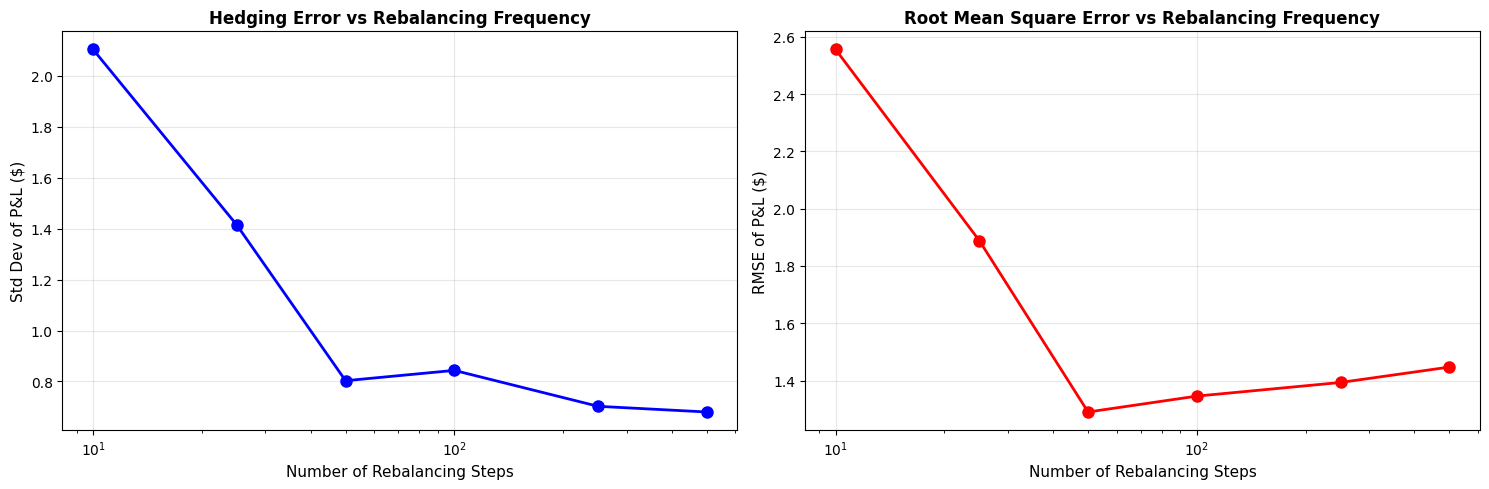

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Standard Deviation vs Frequency
axes[0].plot(error_analysis['frequencies'], error_analysis['std_pnl'], 
             'bo-', linewidth=2, markersize=8)
axes[0].set_xlabel('Number of Rebalancing Steps', fontsize=11)
axes[0].set_ylabel('Std Dev of P&L ($)', fontsize=11)
axes[0].set_title('Hedging Error vs Rebalancing Frequency', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].set_xscale('log')

# RMSE vs Frequency
axes[1].plot(error_analysis['frequencies'], error_analysis['rmse'], 
             'ro-', linewidth=2, markersize=8)
axes[1].set_xlabel('Number of Rebalancing Steps', fontsize=11)
axes[1].set_ylabel('RMSE of P&L ($)', fontsize=11)
axes[1].set_title('Root Mean Square Error vs Rebalancing Frequency', 
                  fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].set_xscale('log')

plt.tight_layout()
plt.show()